In [1]:
import numpy as np
import random
import math
import time

from collections import deque

%matplotlib notebook
import matplotlib
import matplotlib.pyplot

import tensorflow as tf
import gym

In [4]:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In [2]:
envName = "CartPole-v1"

In [3]:
env = gym.make(envName)
state = env.reset()

In [24]:
for _ in range(1000):
    env.render()
    st, rew, done, info = env.step(env.action_space.sample()) # take a random action
    if(done):
        break
#time.sleep(3)
env.reset()
env.close()

In [3]:
class DQN(tf.keras.Model):
    def __init__(self):
        super(DQN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation="relu")
        self.dense2 = tf.keras.layers.Dense(32, activation="relu")
        self.dense3 = tf.keras.layers.Dense(2)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

In [4]:
mainNet = DQN()
targetNet = DQN()

optimizer = tf.optimizers.Adam(1e-4)
mse = tf.keras.losses.MeanSquaredError()

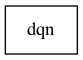

In [6]:
tf.keras.utils.plot_model(mainNet)

In [59]:
mainNet.build((None, 4))

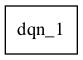

In [7]:
tf.keras.utils.plot_model(targetNet)

In [5]:
class ReplayBuffer(object):
    def __init__(self, size):
        self.buffer = deque(maxlen=size)
    
    def add(self, state, action, reward, nextState, done):
        self.buffer.append((state, action, reward, nextState, done))
    
    def __len__(self):
        return len(self.buffer)
    
    def sample(self, n):
        states, actions, rewards, nextStates, dones = [], [], [], [], []
        ind = np.random.choice(len(self.buffer), n)
        for i in ind:
            elem = self.buffer[i]
            state, action, reward, nextState, done = elem
            states.append(np.array(state,copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            nextStates.append(np.array(nextState, copy=False))
            dones.append(done)
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards, dtype=np.float32)
        nextStates = np.array(nextStates)
        dones = np.array(dones, dtype=np.float32)
        
        return states, actions, rewards, nextStates, dones
        

In [6]:
def selectAction(state, epsilon):
    r = tf.random.uniform((1,))
    if(r < epsilon):
        return env.action_space.sample()
    else:
        return tf.argmax(mainNet(state)[0]).numpy()

In [7]:
@tf.function
def trainStep(states, actions, rewards, nextStates, dones):
    
    nextQs = targetNet(nextStates)
    maxNextQs = tf.reduce_max(nextQs, axis=-1)
    target = rewards + (1. - dones) * discount * maxNextQs
    
    with tf.GradientTape() as tape:
        qs = mainNet(states)
        actionsMask = tf.one_hot(actions, 2)
        maskedQs = tf.reduce_sum(actionsMask * qs, axis=-1)
        loss = mse(target, maskedQs)
        
    grads = tape.gradient(loss, mainNet.trainable_variables)
    optimizer.apply_gradients(zip(grads, mainNet.trainable_variables))

    
    return loss

In [18]:
numEpisode = 1000
epsilon = 0.05
batchSize = 32
discount = 0.99
buffer = ReplayBuffer(100000)
curFrame = 0
epRecord = []

env = gym.make(envName)

for i in range(numEpisode):
    state = env.reset()
    epReward, done = 0.0, False
    
    while(not done):
        stateIn = tf.expand_dims(state, axis=0)
        action = selectAction(stateIn, epsilon)
        nextState, reward, done, info = env.step(action)
        epReward += reward
        
        buffer.add(state, action, reward, nextState, done)
        state = nextState
        
        curFrame += 1
        
        if(curFrame % 2000 == 0):
            targetNet.set_weights(mainNet.get_weights())
        
        if(len(buffer) >= batchSize):
            states, actions, rewards, nextStates, dones = buffer.sample(batchSize)
            loss = trainStep(states, actions, rewards, nextStates, dones)
    
    if(epsilon > 0.05):
        epsilon -= 0.001
    
    if(len(epRecord) == 100):
        epRecord = epRecord[1:]
    epRecord.append(epReward)
    
    if((i+1) % 50 == 0):
        print(f"Episode: {i+1}/{numEpisode}  Epsilon: {epsilon:.3f} 100 Last Reward : {np.mean(epRecord):.3f}")
    
env.close()

Episode: 50/1000  Epsilon: 0.050 100 Last Reward : 242.320
Episode: 100/1000  Epsilon: 0.050 100 Last Reward : 243.760
Episode: 150/1000  Epsilon: 0.050 100 Last Reward : 271.070
Episode: 200/1000  Epsilon: 0.050 100 Last Reward : 316.230
Episode: 250/1000  Epsilon: 0.050 100 Last Reward : 327.490
Episode: 300/1000  Epsilon: 0.050 100 Last Reward : 348.960
Episode: 350/1000  Epsilon: 0.050 100 Last Reward : 359.050
Episode: 400/1000  Epsilon: 0.050 100 Last Reward : 363.380
Episode: 450/1000  Epsilon: 0.050 100 Last Reward : 411.290
Episode: 500/1000  Epsilon: 0.050 100 Last Reward : 461.970
Episode: 550/1000  Epsilon: 0.050 100 Last Reward : 493.470
Episode: 600/1000  Epsilon: 0.050 100 Last Reward : 490.740
Episode: 650/1000  Epsilon: 0.050 100 Last Reward : 469.470
Episode: 700/1000  Epsilon: 0.050 100 Last Reward : 477.960
Episode: 750/1000  Epsilon: 0.050 100 Last Reward : 500.000
Episode: 800/1000  Epsilon: 0.050 100 Last Reward : 486.170
Episode: 850/1000  Epsilon: 0.050 100 Las

In [21]:
#mainNet.save_weights("./weightM/weight2")
#targetNet.save_weights("./weightT/weight2")

In [8]:
mainNet.load_weights("./weightM/weight2")
targetNet.load_weights("./weightT/weight2")

In [11]:
testEnv = gym.make(envName)
state = testEnv.reset()
epRew = 0.0
done = False
while(not done):
    testEnv.render()
    state = tf.expand_dims(state, axis=0)
    action = selectAction(state, 0.01)
    state, reward, done, info = testEnv.step(action)
    epRew += reward
    
testEnv.reset()
testEnv.close()

NameError: name 'env' is not defined